In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

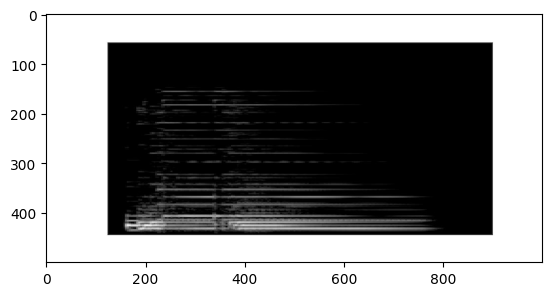

In [15]:
img=cv2.imread('treino/Am/10.jpg',cv2.IMREAD_GRAYSCALE) / 255
plt.imshow(img,cmap='gray')
plt.show()

In [17]:



class Conv_op:
    def __init__(self,num_filters,filter_size):
        self.num_filters=num_filters
        self.filter_size=filter_size
        self.conv_filter=np.random.randn(num_filters,filter_size,filter_size) / (filter_size * filter_size)
    def image_region(self,image):
        heigth,width = image.shape
        self.image=image

        for j in range(heigth - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch=image[j:(j + self.filter_size),k:(k + self.filter_size)]
                yield image_patch, j, k
    
    def forward_prop(self,image):
        heigth,width=image.shape
        conv_out=np.zeros((heigth - self.filter_size + 1,width - self.filter_size + 1,self.num_filters))
        for image_patch,i,j in self.image_region(image):
            conv_out[i,j]=np.sum(image_patch*self.conv_filter,axis=(1,2))
        return conv_out
    
    def back_prop(self,dl_dout,learning_rate):
        dl_df_params=np.zeros(self.conv_filter.shape)
        for image_patch,i,j in self.image_region(self.image):
            for k in range(self.num_filters):
                dl_df_params[k] += image_patch*dl_dout[i,j,k]

        self.conv_filter -= learning_rate * dl_df_params
        return dl_df_params

In [18]:
conn=Conv_op(18,7)
out=conn.forward_prop(img)
out.shape

(494, 994, 18)

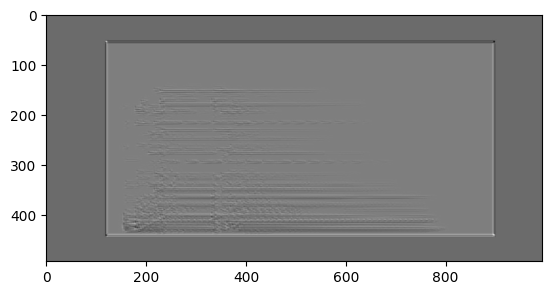

In [19]:
plt.imshow(out[:,:,17],cmap='gray')
plt.show()

In [20]:
class Max_Pool:
    def __init__(self,filter_size):
        self.filter_size=filter_size
    def image_region(self,image):
        new_heigth=image.shape[0] // self.filter_size
        new_width=image.shape[1] // self.filter_size
        self.image=image

        for i in range(new_heigth):
            for j in range(new_width):
                image_patch=image[(i * self.filter_size) : (i * self.filter_size + self.filter_size),(j * self.filter_size):(j*self.filter_size + self.filter_size)]
                yield image_patch,i,j
    
    def forward_prop(self,image):
        heigth,width,num_filters=image.shape
        output=np.zeros((heigth// self.filter_size,width//self.filter_size,num_filters))

        for image_patch,i,j in self.image_region(image):
            output[i,j]=np.amax(image_patch,axis=(0,1))
        return output
    
    def back_prop(self,dl_dout):
        dl_dmax_pool=np.zeros(self.image.shape)
        for image_patch,i,j in self.image_region(self.image):
            heigth,width,num_filters=image_patch.shape
            maximun_val=np.amax(image_patch,axis=(0,1))

            for i1 in range(heigth):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1,j1,k1] == maximun_val[k1]:
                            dl_dmax_pool[i*self.filter_size + i1,j*self.filter_size + j1,k1] = dl_dout[i,j,k1]
        return dl_dmax_pool

In [21]:
conn2=Max_Pool(4)
out2=conn2.forward_prop(out)
out2.shape

(123, 248, 18)

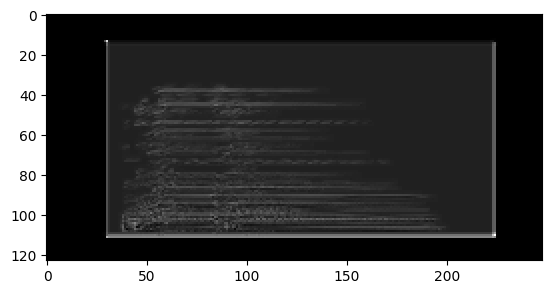

In [22]:
plt.imshow(out2[:,:,17],cmap='gray')
plt.show()

In [27]:
class Softmax:
    def __init__(self,input_node,softmax_node):
        self.weigth=np.random.randn(input_node,softmax_node)/input_node
        self.bias=np.zeros(softmax_node)
    def forward_prop(self,image):
        self.orig_im_shape=image.shape
        image_modified=image.flatten()
        self.modified_input=image_modified
        output_val=np.dot(image_modified,self.weigth) + self.bias
        self.out=output_val
        exp_out=np.exp(output_val)
        return exp_out/np.sum(exp_out,axis=0)
    
    def back_prop(self,dl_out,learning_rate):
        for i,grad in enumerate(dl_out):
            if grad == 0:
                continue
            transformation_eq=np.exp(self.out)
            s_total=np.sum(transformation_eq)

            dy_dz=-transformation_eq[i] * transformation_eq/(s_total**2)
            dy_dz[i]=transformation_eq[i]*(s_total - transformation_eq[i])/(s_total **2)

            dz_dw=self.modified_input
            dz_db=1
            dz_d_inp=self.weigth

            dl_dz=grad * dy_dz

            dl_dw=dz_dw[np.newaxis].T @ dl_dz[np.newaxis]
            dl_db=dl_dz * dz_db
            dl_d_inp=dz_d_inp @ dl_dz
            self.weigth -= learning_rate * dl_dw
            self.bias -= learning_rate * dl_db

            return dl_d_inp.reshape(self.orig_im_shape)

In [29]:
conn3=Softmax(123*248*18,10)
out3=conn3.forward_prop(out2)
print(out3)

[0.1000069  0.1000133  0.09997492 0.09999776 0.09999735 0.10001091
 0.10000044 0.10000041 0.10000377 0.09999424]


In [ ]:
conv=Conv_op(8,3)
pool=Max_Pool(2)
softmax=Softmax(13*13*8,10)

def cnn_forward_prop(image,label):
    out_p=conv.forward_prop((image/255)-0.5)
    out_p=pool.forward_prop(out_p)
    out_p=softmax.forward_prop(out_p)

    cross_ent_loss=-np.log(out_p[label])
    accuracy_eval=1 if np.argmax(out_p) == label else 0

    return out_p,cross_ent_loss,accuracy_eval

In [ ]:
def training_cnn(image,label,learning_rate=0.005):
    out,loss,acc=cnn_forward_prop(image,label)

    gradient=np.zeros(10)
    gradient[label] = -1/out[label]

    grad_back=softmax.back_prop(gradient,learning_rate)
    grad_back=pool.back_prop(grad_back)
    grad_back=conv.back_prop(grad_back,learning_rate)

    return loss,acc

In [ ]:
for epoch1 in range(4):
    print('epoch %d -->'%(epoch1 + 1))

    shuffle_data=np.random.permutation(len(train_images))
    train_images=train_images[shuffle_data]
    train_labels=train_labels[shuffle_data]

    loss=0
    num_correct=0

    for i,(im,label) in enumerate(zip(train_images,train_labels)):
        if i%100 == 0:
            print('loss %.3f accuracy %d%%'%(i+1,loss/100,num_correct))
            loss = 0
            num_correct=0

            l1,accu=training_cnn(im,label)
            loss +=l1
            num_correct +=accu
        